In [41]:
#general testing with gaussian
def gaussian2Dtest(points,mx,my,N,C):
    """
    Gaussian function in 2D:
    - points = (x,y) is the grid array at which the function is being evaluated
    - (mx,my) = (mu_x,mu_y) is the centre of the distribution
    - (ax,ay) = (alpha_x,alpha_y) = [1/(2 * sigma_x^2),1/(2 * sigma_y^2)]
    - N is an arbitrary normalization constant
    - C is a baseline constant
    """
    theta = np.pi/3
    
    FWHM_x = 1                             #FWHM value ?
    sig_x = FWHM_x /(2*np.sqrt(2*np.log(2)))
    a_x = 1/(2*sig_x**2)
    
    FWHM_y = 2                             #FWHM value ?
    sig_y = FWHM_y /(2*np.sqrt(2*np.log(2)))
    a_y = 1/(2*sig_y**2)
    
    #tilted ellipse parameters
    A = np.cos(theta)**2/sig_x**2 + np.sin(theta)**2/sig_y**2
    C = np.cos(theta)**2/sig_y**2 + np.sin(theta)**2/sig_x**2
    B = 2*np.cos(theta)*np.sin(theta)*(1/sig_x**2 - 1/sig_y**2)
    
    x,y = points
    z = N * np.exp( 1/2*(- A*(x-mx)**2 - B*x*y - C*(y-my)**2 )) + C
    return z

In [157]:
"""
This script simulates the centre of a Hub-Filament System with saturated pixels
"""

### imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def gaussian2D(points,mx,my,N):
	"""
	Gaussian function in 2D:
		- points = (x,y) is the grid array at which the function is being evaluated
		- (mx,my) = (mu_x,mu_y) is the centre of the distribution
		- a = alpha = [1/(2 * sigma^2)]
		- N is an arbitrary normalization constant
	"""
	FWHM_x = 4.96
	sig_x = FWHM_x /(2*np.sqrt(2*np.log(2)))
	a_x = 1/(2*sig_x**2)
    
	FWHM_y = 4.96
	sig_y = FWHM_y /(2*np.sqrt(2*np.log(2)))
	a_y = 1/(2*sig_y**2)


	x,y = points
	z = N * np.exp( - a_x*(x-mx)**2 - a_y*(y-my)**2) 
	return z

def gaussian2Dmult(points,*args):
	""" Sum multiple 2D gaussian functions. """
	z = 0
	for i in range(len(args)//3):
		mx,my,N = args[3*i:3*(i+1)]
		z += gaussian2D(points,mx,my,N)
	return z



def fitm(grid,data,sat,peaks=1):
	"""
	Function takes array image, its grid and boolean array of same shape,
	which is True where pixels are saturated and False elsewhere.
	Returns the image with saturated pixels corrected.
	Saturated pixels in data can be represented by both 'nan' and 0 (zero) values.
	"""
	Ndata = np.count_nonzero(sat==False) # number of usable data points
	Nx,Ny = data.shape # number of points in x and y axes
	X,Y = grid # index grid
	print(len(sat))
	mu_x = np.round(X[sat].mean(),3)
	mu_y = np.round(Y[sat].mean(),3)

	FWHM = 3*20.2/18

	N = data[np.isnan(data)==False].max()

	peak_params = np.array([mu_x,mu_y,N])
	guess_params = peak_params.copy()
	for i in range(1,peaks):
		var = FWHM*np.random.normal(size=3)
		guess_params = np.concatenate((guess_params,peak_params+var))


	fit_x = np.empty([2,Ndata],float)
	fit_data = np.empty(Ndata,float)
	k = 0
	for i in range(Nx):
		for j in range(Ny):
			if sat[i,j]:
				continue
			else:
				fit_x[:,k] = np.array([X[i,j],Y[i,j]])
				fit_data[k] = data[i,j]
			k += 1

	params,cov = curve_fit(gaussian2Dmult,fit_x,fit_data,guess_params,maxfev=4000)
	image = gaussian2Dmult((X,Y),*params)
	image[sat==False] = data[sat==False]
	return params,image

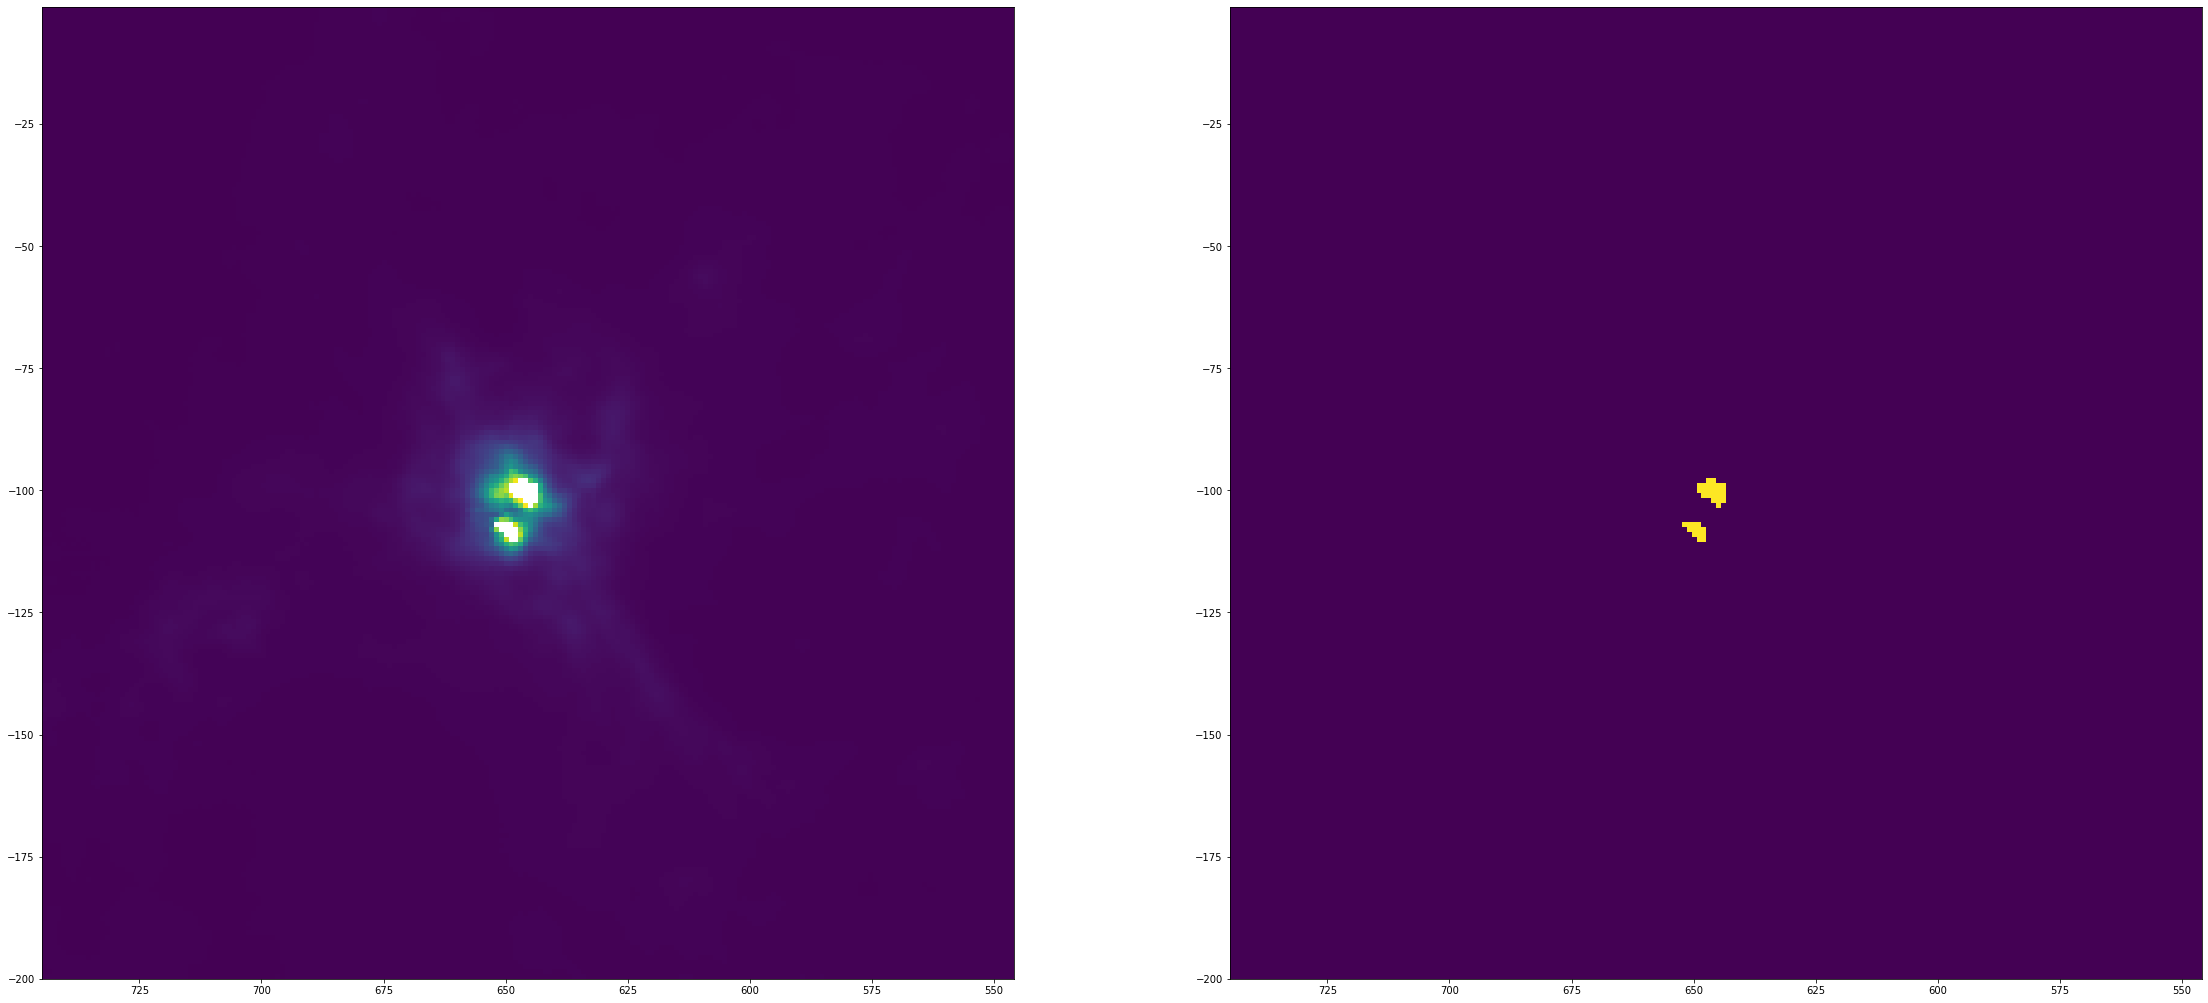

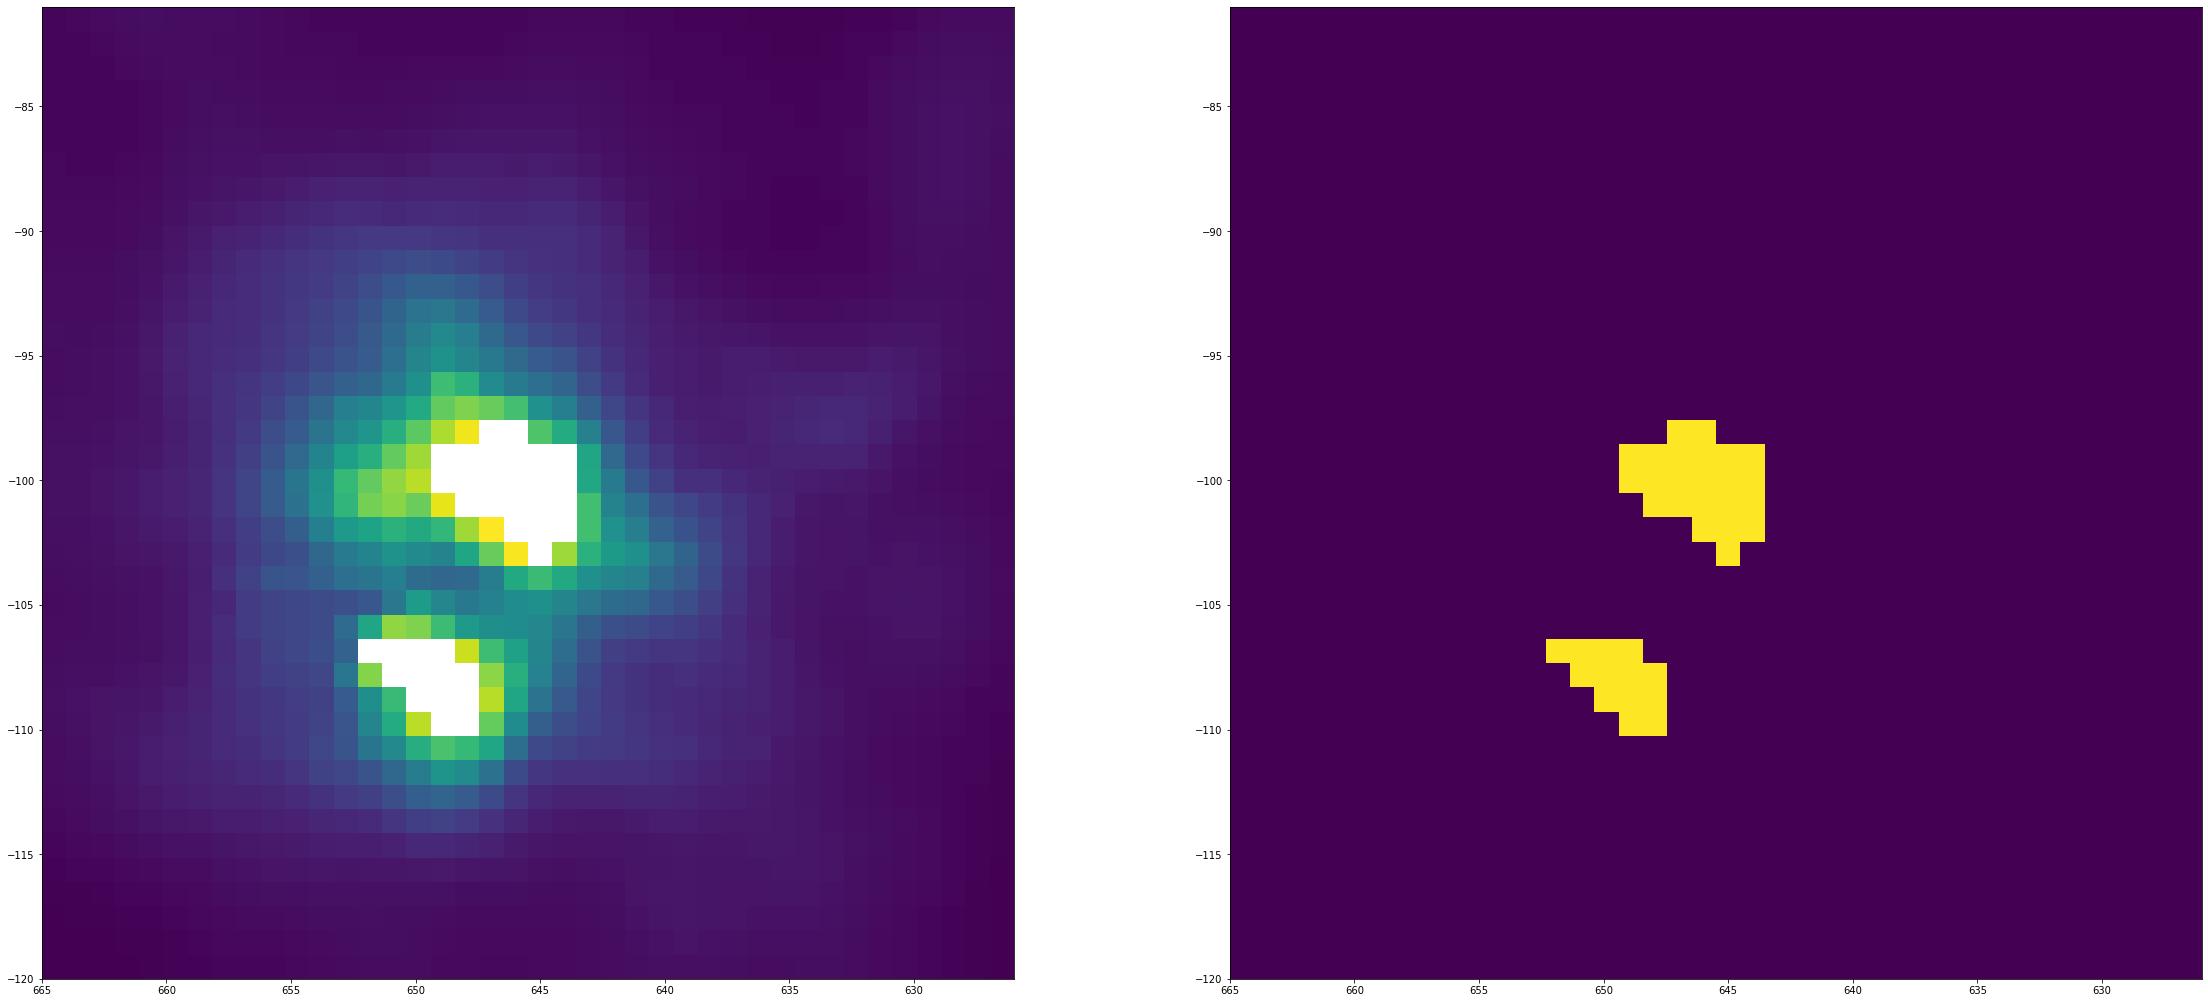

In [2]:
# import modules

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits


    
# open fits file
# hdu = fits.open('sat_images/satexample1.fits')[0]
hdu = fits.open('im250_sat_13_cutout.fits')[0]
header = hdu.header
data0 = hdu.data

#data0[data0==np.min(data0)] = np.nan
sat_area = np.zeros(data0.shape,bool)
sat_area[np.isnan(data0)] = True
sat_area[data0==0] = True

# axis values from header
x0,y0 = header['crpix1'],header['crpix2']
dx,dy = header['cdelt1'],header['cdelt2']
nx,ny = header['naxis1'],header['naxis2']
x = x0 + dx/abs(dx)*np.arange(0,nx)
y = y0 + dy/abs(dy)*np.arange(0,ny)
grid = np.meshgrid(x,y)

# plot and show image
fig = plt.figure(figsize=(30,15*ny/nx))
ax1 = plt.axes([0,0,0.45,1])
ax2 = plt.axes([0.55,0,0.45,1])
ax1.imshow(data0,origin='lower',extent=(x[0],x[-1],y[0],y[-1]))
ax2.imshow(sat_area,origin='lower',extent=(x[0],x[-1],y[0],y[-1]))
plt.show()

M,N=len(data0),len(data0[0])
lim1x,lim1y = int(M*0.4),int(N*0.4)
lim2x,lim2y = int(M*0.6),int(N*0.6)

data0 = data0[lim1x:lim2x,lim1y:lim2y]
sat_area = sat_area[lim1x:lim2x,lim1y:lim2y]
x = x[lim1x:lim2x]
y = y[lim1y:lim2y]
grid = np.meshgrid(x,y)
fig = plt.figure(figsize=(30,15*ny/nx))
ax1 = plt.axes([0,0,0.45,1])
ax2 = plt.axes([0.55,0,0.45,1])
ax1.imshow(data0,origin='lower',extent=(x[0],x[-1],y[0],y[-1]))
ax2.imshow(sat_area,origin='lower',extent=(x[0],x[-1],y[0],y[-1]))
plt.show()

40
[ 6.47914259e+02 -9.97366875e+01  1.63681443e+05  6.48971690e+02
 -1.08492144e+02  1.60056647e+05]


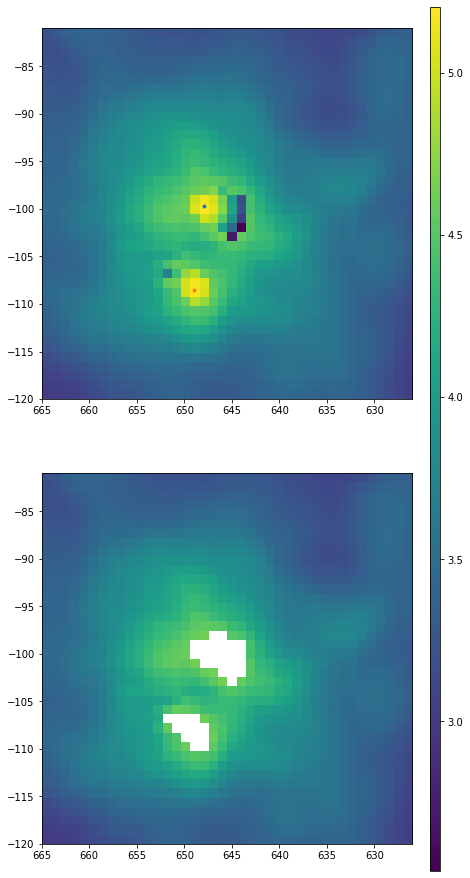

In [3]:
n_peaks = 2

params,image = fitm(grid,data0,sat_area,peaks=n_peaks)
min_val,max_val = np.min(np.log10(image)),np.max(np.log10(image))
print(params)

fig,axs = plt.subplots(2,1,figsize=(15,15*ny/nx))
ax1 = axs[0].imshow(np.log10(image),origin='lower',extent=(x[0],x[-1],y[0],y[-1]),vmin=min_val,vmax=max_val)
ax2 = axs[1].imshow(np.log10(data0),origin='lower',extent=(x[0],x[-1],y[0],y[-1]),vmin=min_val,vmax=max_val)
cax = plt.axes([0.7, 0.1, 0.01, 0.8])

for i in range(n_peaks):
    axs[0].plot(params[i*3],params[i*3+1],'.')
    
plt.colorbar(ax1,cax=cax)
plt.show()

#plt.imshow(np.log10(np.abs(image-data0)),origin='lower')
#plt.colorbar()
#plt.show()

# Eliptical Gaussian

In [57]:
#general testing with gaussian
def gaussian2D(points,mx,my,N,theta):
	"""
	Gaussian function in 2D:
	- points = (x,y) is the grid array at which the function is being evaluated
	- (mx,my) = (mu_x,mu_y) is the centre of the distribution
	- (ax,ay) = (alpha_x,alpha_y) = [1/(2 * sigma_x^2),1/(2 * sigma_y^2)]
	- N is an arbitrary normalization constant
	- C is a baseline constant
	"""
	#theta = 0
    
	FWHM_x = 4.96
	sig_x = FWHM_x /(2*np.sqrt(2*np.log(2)))
	a_x = 1/(2*sig_x**2)
    
	FWHM_y = 4.96
	sig_y = FWHM_y /(2*np.sqrt(2*np.log(2)))
	a_y = 1/(2*sig_y**2)
    
	#tilted ellipse parameters
	A = np.cos(theta)**2/sig_x**2 + np.sin(theta)**2/sig_y**2
	C = np.cos(theta)**2/sig_y**2 + np.sin(theta)**2/sig_x**2
	B = 2*np.cos(theta)*np.sin(theta)*(1/sig_x**2 - 1/sig_y**2)
    
	x,y = points
	z = N * np.exp( 1/2*(- A*(x-mx)**2 - B*x*y - C*(y-my)**2) )
	return z


def gaussian2Dmult(points,*args):
	""" Sum multiple 2D gaussian functions. """
	z = 0
	for i in range(len(args)//4):
		mx,my,N,theta = args[4*i:4*(i+1)]
		z += gaussian2D(points,mx,my,N,theta)
	return z


def fitm(grid,data,sat,peaks=1):
	"""
	Function takes array image, its grid and boolean array of same shape,
	which is True where pixels are saturated and False elsewhere.
	Returns the image with saturated pixels corrected.
	Saturated pixels in data can be represented by both 'nan' and 0 (zero) values.
	"""
	Ndata = np.count_nonzero(sat==False) # number of usable data points
	Nx,Ny = data.shape # number of points in x and y axes
	X,Y = grid # index grid

	mu_x = np.floor(X[sat].mean())
	mu_y = np.floor(Y[sat].mean())
	theta_g = np.tan(mu_y/mu_x)

	FWHM = 4.96#3*18.2/18

	N = data[np.isnan(data)==False].max()

	peak_params = np.array([mu_x,mu_y,N,theta_g])
	guess_params = peak_params.copy()
	for i in range(1,peaks):
		var = FWHM*np.random.normal(size=4)
		guess_params = np.concatenate((guess_params,peak_params+var))


	fit_x = np.empty([2,Ndata],float)
	fit_data = np.empty(Ndata,float)
	k = 0
	for i in range(Nx):
		for j in range(Ny):
			if sat[i,j]:
				continue
			else:
				fit_x[:,k] = np.array([X[i,j],Y[i,j]])
				fit_data[k] = data[i,j]
			k += 1

	params,cov = curve_fit(gaussian2Dmult,fit_x,fit_data,guess_params,maxfev=4000)
	image = gaussian2Dmult((X,Y),*params)
	image[sat==False] = data[sat==False]
	return params,image

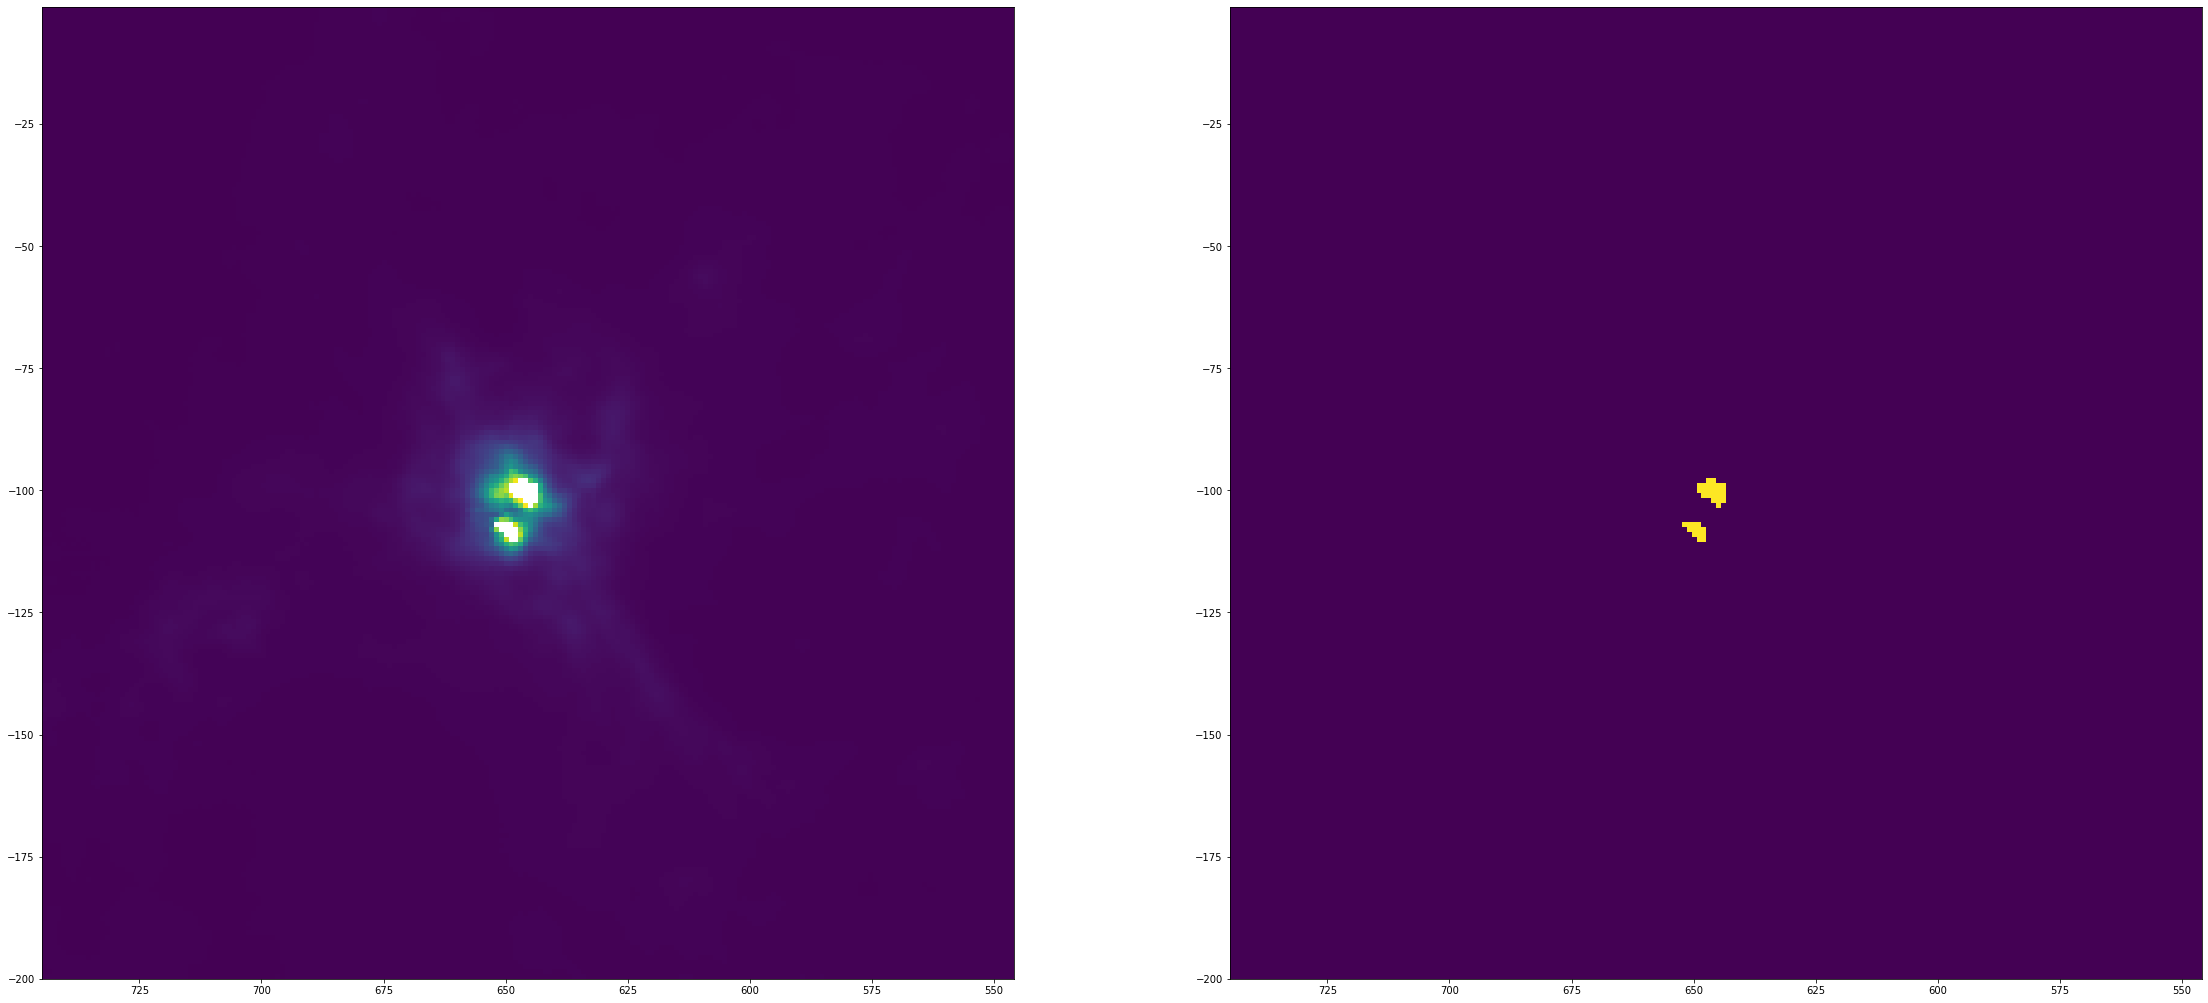

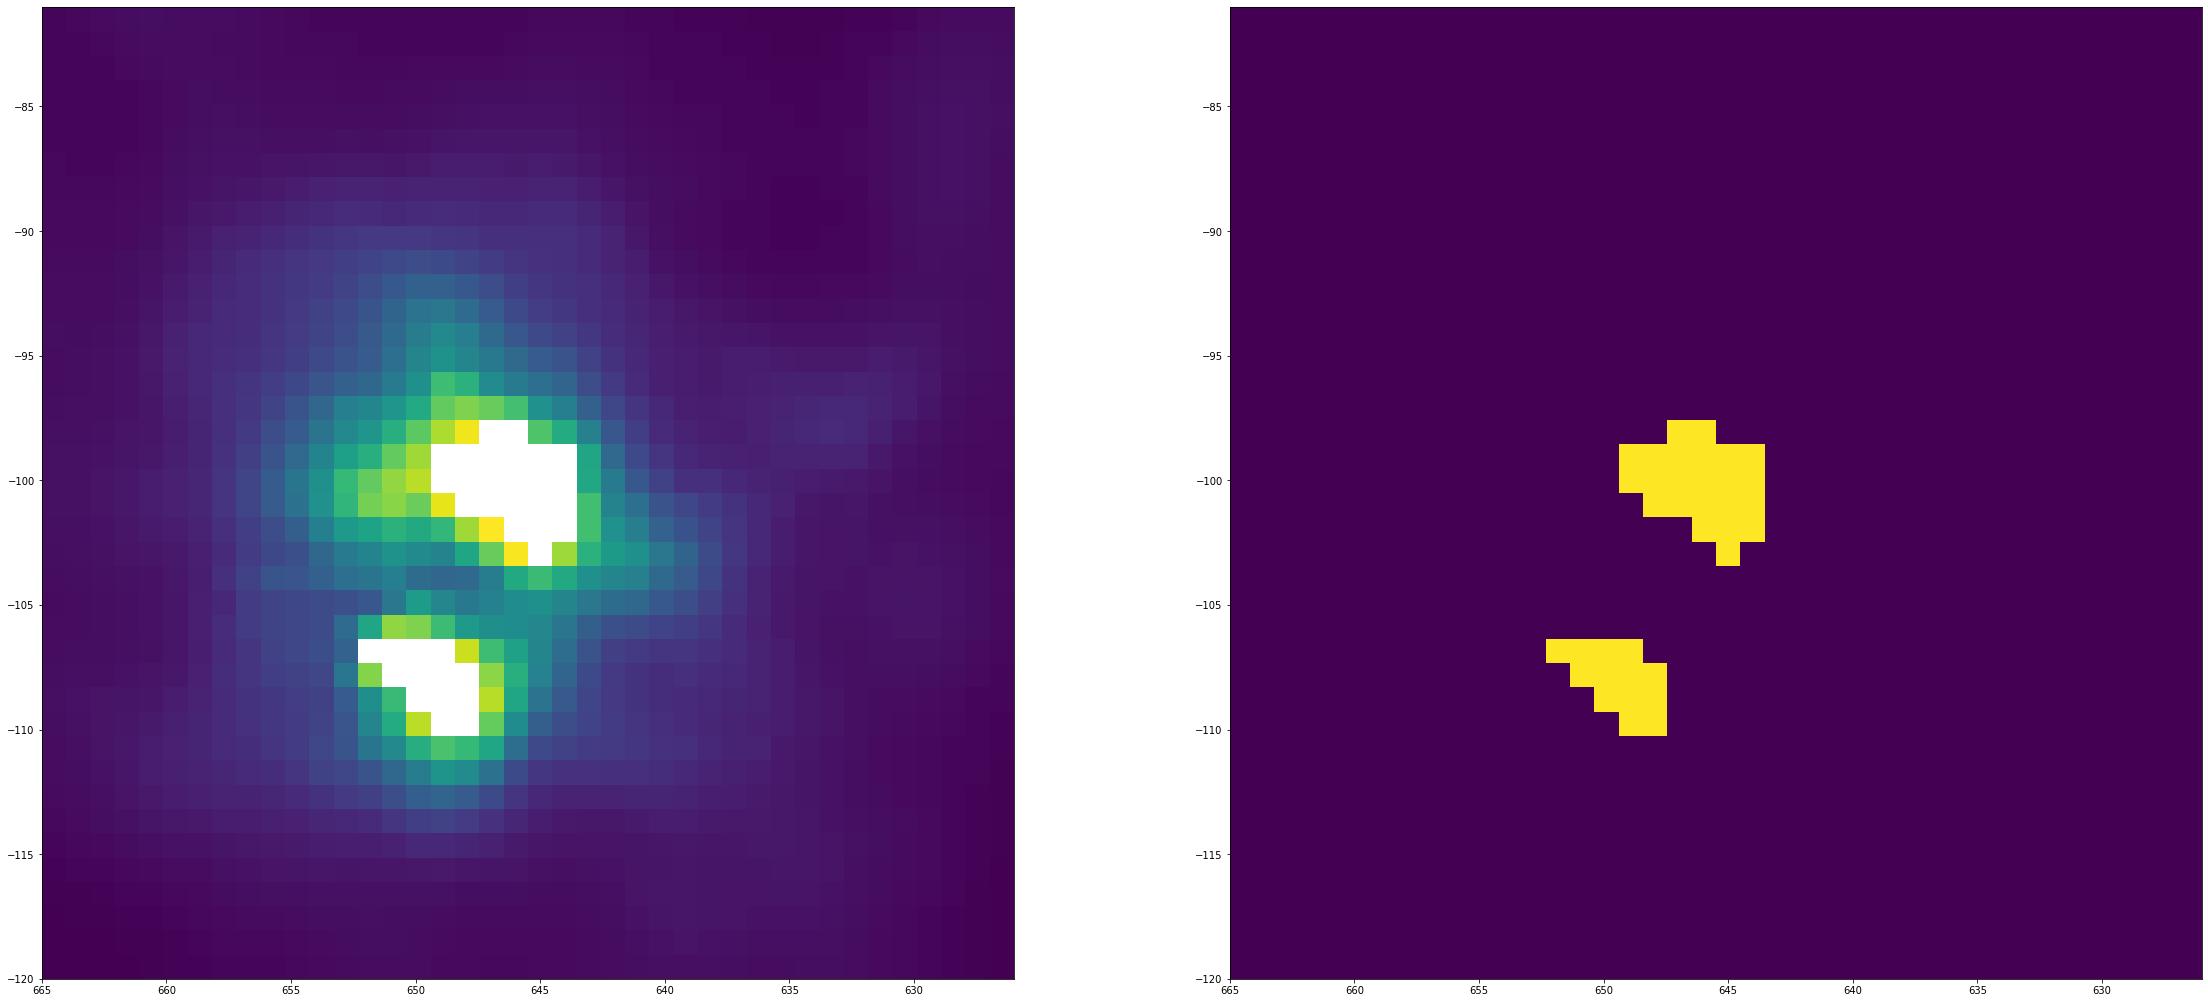

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits


    
# open fits file
# hdu = fits.open('sat_images/satexample1.fits')[0]
hdu = fits.open('im250_sat_13_cutout.fits')[0]
header = hdu.header
data0 = hdu.data

#data0[data0==np.min(data0)] = np.nan
sat_area = np.zeros(data0.shape,bool)
sat_area[np.isnan(data0)] = True
sat_area[data0==0] = True

# axis values from header
x0,y0 = header['crpix1'],header['crpix2']
dx,dy = header['cdelt1'],header['cdelt2']
nx,ny = header['naxis1'],header['naxis2']
x = x0 + dx/abs(dx)*np.arange(0,nx)
y = y0 + dy/abs(dy)*np.arange(0,ny)
grid = np.meshgrid(x,y)

# plot and show image
fig = plt.figure(figsize=(30,15*ny/nx))
ax1 = plt.axes([0,0,0.45,1])
ax2 = plt.axes([0.55,0,0.45,1])
ax1.imshow(data0,origin='lower',extent=(x[0],x[-1],y[0],y[-1]))
ax2.imshow(sat_area,origin='lower',extent=(x[0],x[-1],y[0],y[-1]))
plt.show()

M,N=len(data0),len(data0[0])
lim1x,lim1y = int(M*0.4),int(N*0.4)
lim2x,lim2y = int(M*0.6),int(N*0.6)

data0 = data0[lim1x:lim2x,lim1y:lim2y]
sat_area = sat_area[lim1x:lim2x,lim1y:lim2y]
x = x[lim1x:lim2x]
y = y[lim1y:lim2y]
grid = np.meshgrid(x,y)
fig = plt.figure(figsize=(30,15*ny/nx))
ax1 = plt.axes([0,0,0.45,1])
ax2 = plt.axes([0.55,0,0.45,1])
ax1.imshow(data0,origin='lower',extent=(x[0],x[-1],y[0],y[-1]))
ax2.imshow(sat_area,origin='lower',extent=(x[0],x[-1],y[0],y[-1]))
plt.show()

[ 6.49022723e+02 -1.08434217e+02  7.19878192e+04  9.75787552e+06
  6.47062901e+02 -9.97671570e+01  1.05130050e+05 -8.58890925e+08]
64686.184280895424


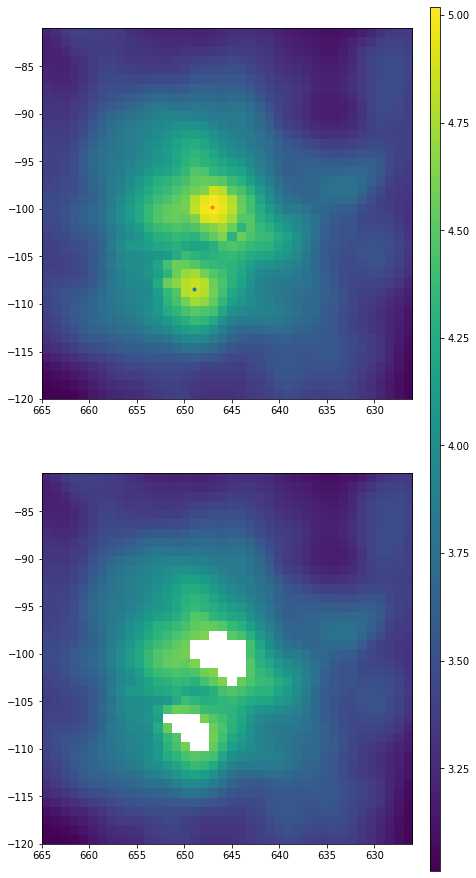

In [79]:
n_peaks = 2

params,image = fitm(grid,data0,sat_area,peaks=n_peaks)
min_val,max_val = np.min(np.log10(image)),np.max(np.log10(image))
print(params)
print(image[20,20])

fig,axs = plt.subplots(2,1,figsize=(15,15*ny/nx))
ax1 = axs[0].imshow(np.log10(image),origin='lower',extent=(x[0],x[-1],y[0],y[-1]),vmin=min_val,vmax=max_val)
ax2 = axs[1].imshow(np.log10(data0),origin='lower',extent=(x[0],x[-1],y[0],y[-1]),vmin=min_val,vmax=max_val)
cax = plt.axes([0.7, 0.1, 0.01, 0.8])

for i in range(n_peaks):
    axs[0].plot(params[i*4],params[i*4+1],'.')
    
plt.colorbar(ax1,cax=cax)
plt.show()

#plt.imshow(np.log10(np.abs(image-data0)),origin='lower')
#plt.colorbar()
#plt.show()

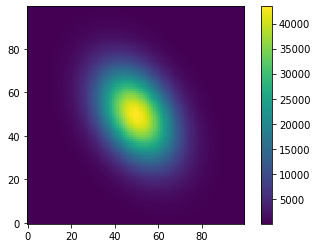

In [177]:
x,y=np.linspace(-10,10,100),np.linspace(-10,10,100)
grid = np.meshgrid(x,y)
image = gaussian2D(grid,0,0,4.349e4,8.39)
plt.imshow(image,origin="bottom")
plt.colorbar()

# Fits auto loop

im070_sat_2_selected.fits :


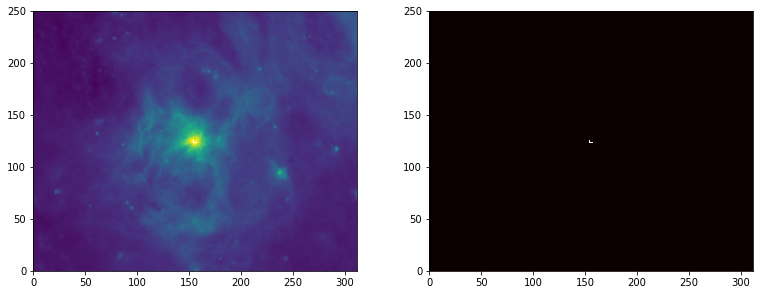

[120 170 100 150   1]
50


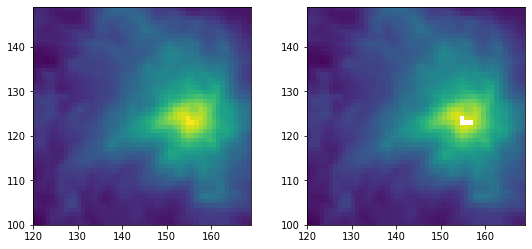

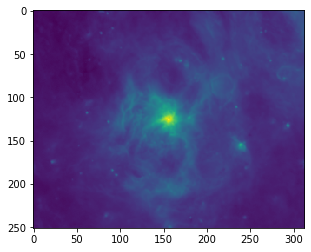

im160_sat_2_selected.fits :


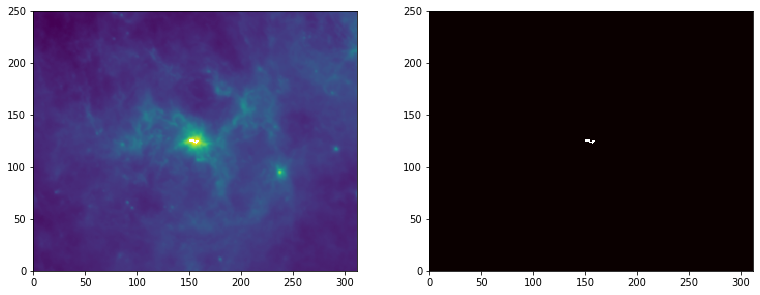

[120 170 100 150   2]
50


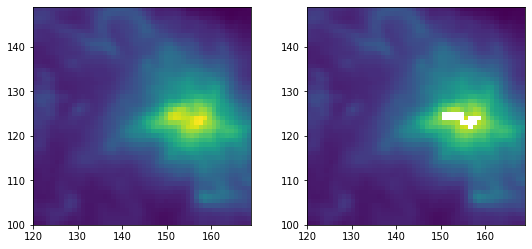

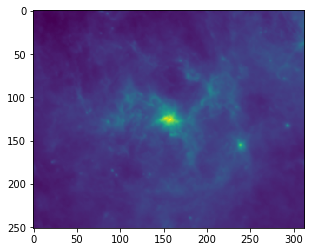

im250_sat_2_selected.fits :


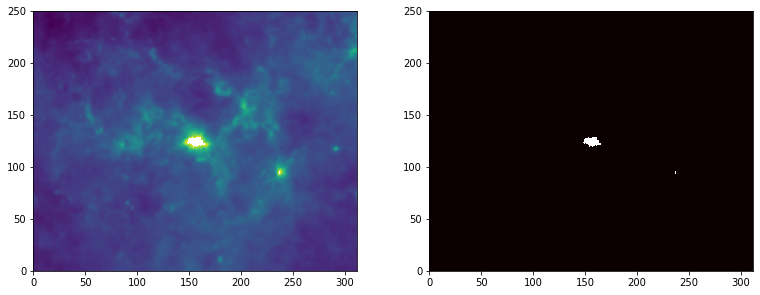

[120 170 100 150   2]
50


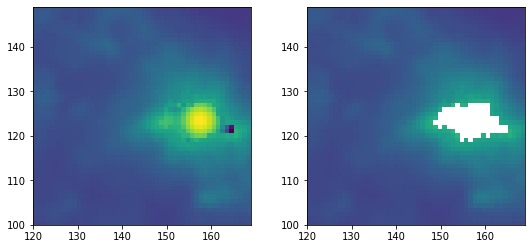

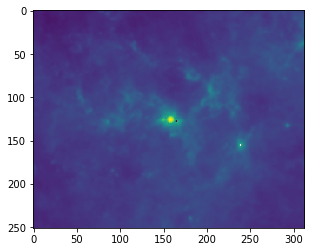

im350_sat_2_selected.fits :


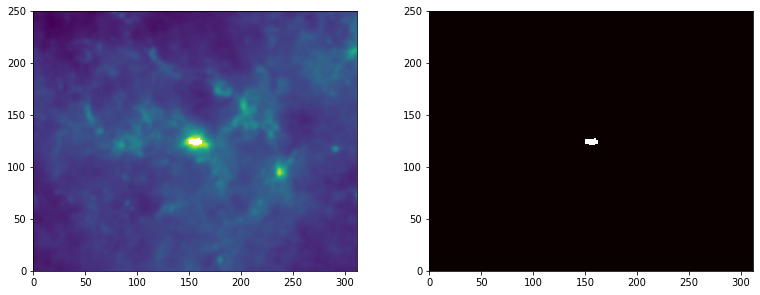

[140 170 110 140   2]
30


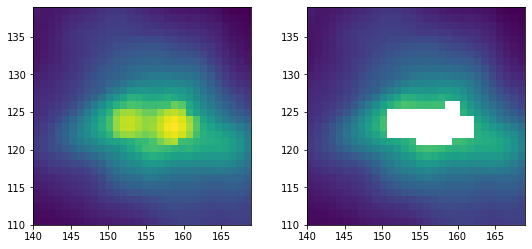

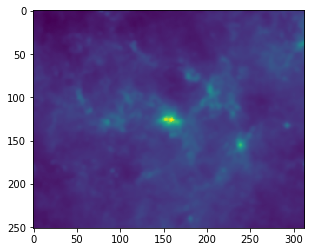

im500_sat_2_selected.fits :


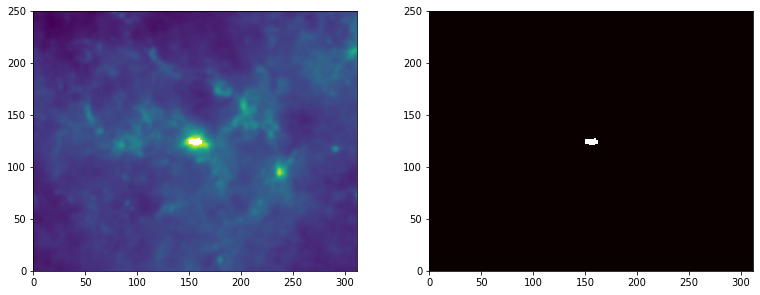

[140 170 110 140   2]
30


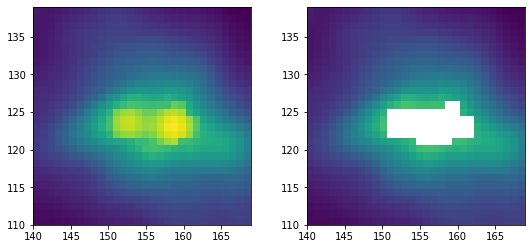

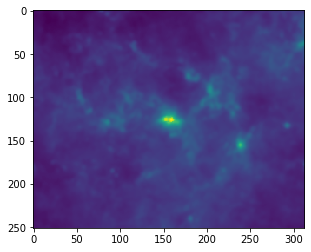

In [158]:
""" Correct second picture """

import os

# Saturated pixel blobs at different wavelengths
tags=["070","160","250","350","500"]
sat_areas70  = np.array([[120,170,100,150,1]])
sat_areas160 = np.array([[120,170,100,150,2]])
sat_areas250 = np.array([[120,170,100,150,2],
                        [120,170,100,150,2]])
sat_areas350 = np.array([[140,170,110,140,2]])
sat_areas500 = np.array([[140,170,110,140,2]])

sat_area_list = [sat_areas70,sat_areas160,sat_areas250,sat_areas350,sat_areas500]

# loop
files = os.listdir('selected')
files.sort()


filenum = 2 #number of the file 

current_wavelength = 0
for index in range(filenum-1,len(files),8):
    # open fits file
    hdu = fits.open('selected/'+files[index])[0]
    header = hdu.header
    data = hdu.data
    #data[data==0] = np.nan
    sat_area = np.zeros(data.shape,bool)
    sat_area[np.isnan(data)] = True

    # axis values from header
    x0,y0 = header['crpix1'],header['crpix2']
    dx,dy = header['cdelt1'],header['cdelt2']
    nx,ny = header['naxis1'],header['naxis2']
    x = np.arange(0,nx)#x0 + dx/abs(dx)*np.arange(0,nx)
    y = np.arange(0,ny)#y0 + dy/abs(dy)*np.arange(0,ny)
    grid = np.meshgrid(x,y)

    # plot and show image
    print(files[index],':')
    fig = plt.figure(figsize=(10,10*ny/nx))
    ax1 = plt.axes([0,0,0.45,1])
    ax2 = plt.axes([0.55,0,0.45,1])
    ax1.imshow(np.log10(data),origin='upper',extent=(x[0],x[-1],y[0],y[-1]))
    ax2.imshow(sat_area,origin='upper',extent=(x[0],x[-1],y[0],y[-1]),cmap='hot')
    plt.show()

    
    for i,lims in enumerate(sat_area_list[current_wavelength]):
        print(lims)
        lim1,lim2,lim3,lim4,n_peaks = lims
        data_sub = data[lim3:lim4,lim1:lim2].copy()
        sat_area_sub = sat_area[lim3:lim4,lim1:lim2].copy()
        x_sub = x[lim1:lim2].copy()
        y_sub = y[lim3:lim4].copy()
        grid_sub = np.meshgrid(x_sub,y_sub)

        if sat_area.any()==False:
            continue

        params,image_sub = fitm(grid_sub,data_sub,sat_area_sub,peaks=n_peaks)
        
        if i==0: 
            correct_data = data.copy()
        correct_data[lim3:lim4,lim1:lim2] = image_sub
        fits.writeto('sat_images_corrected/im{lamb}_sat_{num}_fixed.fits'.format(lamb=tags[current_wavelength],num=filenum),correct_data,header,overwrite=True)
        
        
        min_val,max_val = np.min(np.log10(image_sub)),np.max(np.log10(image_sub))
        extent_vals = (x_sub[0],x_sub[-1],y_sub[0],y_sub[-1])
        fig,axs = plt.subplots(1,2,figsize=(9,5*ny/nx))
        ax1 = axs[0].imshow(np.log10(image_sub),origin='upper',extent=extent_vals,vmin=min_val,vmax=max_val)
        ax2 = axs[1].imshow(np.log10(data_sub),origin='upper',extent=extent_vals,vmin=min_val,vmax=max_val)
        #cax = plt.axes([1, 0.1, 0.01, 0.8])
        #for i in range(n_peaks):
            #axs[0].plot(params[i*3],params[i*3+1],'.')
        #for i in range(2):
        #   axs[i].set_xlim(lim1,lim2)
        #   axs[i].set_ylim(lim3,lim4)
        #plt.colorbar(ax1,cax=cax)
        
        plt.show()
        
        plt.imshow(np.log10(correct_data),origin="upper")
        plt.show()
    current_wavelength += 1

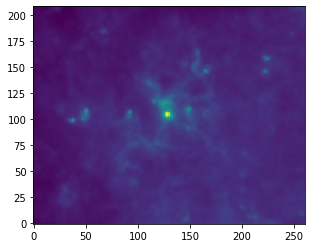

In [50]:
testhdu = fits.open('sat_images_corrected/im250_sat_3_fixed.fits')[0]
data=testhdu.data
plt.imshow(np.log10(data),origin="bottom")